# Animal shelter data

I want to analyse the data from the animal center at the city of Austin. There are several questions that can be addressed using the data.

* How effective is the shelter at its mission? 

How likely are the animals to get adopted after coming to the shelter? How likely are they to die or be put down and never find a home? How can the death and euthanasia rates be reduced?

* What causes people to surrender their animals?

While most of the animals in the center were found as strays, there are still thousands of animals that have been voluntarity surrendered by citizens. Can we determine any factors causing people to do that, and thuse potentially reduce the surrender rate in the future?

* What factors deternime the likelihood of adoption?

How do factors age, breed, color, length of time spent in the shelter influence thje adoption outcome? Can we predict how likely is an animal to be adopted based on these characteristics alone?

I picked this project for a very simple reason: I work at an animal shelter myself, and so it is very important to me that to determine ways in which we can reduce the number of animals in shelters and increase the adoption rates. This also gived me some insight into what to expect of the data, and what steps could be taken depending on the analysis.

Finally, here's me with the most talkative kitten on the planet!
![alt text](https://68.media.tumblr.com/32c84d6fcbbbc8084d95d27164e1f8c4/tumblr_p0ng5jKtQr1r4pvvno1_250.jpg "Me and Chewbacca the kitten")
Chewbacca (right) was adopted in December 2017.

## The data

The data is provided by the City of Austin Open Data portal via the Socrata API. I use two datasets --  [the intakes](https://data.austintexas.gov/Health-and-Community-Services/Austin-Animal-Center-Intakes/wter-evkm) and [the outcomes](https://data.austintexas.gov/Health-and-Community-Services/Austin-Animal-Center-Outcomes/9t4d-g238) -- which are connected by the unique Animal ID.

Intakes dataset includes information about intake time, state,  age, breed, color of the animal, and the outcomes dataset is similar. The data listed spans from October 2013 to the present day. In this project, I will only focus on cats and dogs.

I shouls note that this is not the only such datasets available, just one of the largest and more complete ones. Similar data are provided by the animal services of [Dallas](https://www.dallasopendata.com/City-Services/FY-2017-Dallas-Animal-Shelter-Data/sjyj-ydcj), [Los Angeles](https://data.lacity.org/A-Well-Run-City/Animal-Services-Intake-Data/8cmr-fbcu) (intake only), [Sonoma County](https://data.sonomacounty.ca.gov/Government/Animal-Shelter-Intake-and-Outcome/924a-vesw/), and others. 

This project will be more meaningful if performing the same analysis on datasets from other locations will reveal the same results.

## Surrenders

In a perfect world, no animal would ever be homeless, and no pet owner would ever give up their pet. However, as we can see from the dataset, a number of animals have been surrendered by their owners. I am interested in determining what causes a person to surrender their animal to animal services? One of the things to consider is age (younger animals are harder to handle) and breed (certain dog breeds tend to have undesirable behaviousal issues).

Let's look at age first:

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sodapy import Socrata

# Load the data
client = Socrata("data.austintexas.gov", None)

intake_records = client.get("fdzn-9yqv", limit = 100000)
intake = pd.DataFrame.from_records(intake_records)

outcomes_records = client.get("hcup-htgu", limit = 100000)
outcomes = pd.DataFrame.from_records(outcomes_records)

# Keep only records about cats and dogs
intake = intake[(intake['animal_type'] == 'Cat') | (intake['animal_type'] == 'Dog')] 
outcomes = outcomes[(outcomes['animal_type'] == 'Cat') | (outcomes['animal_type'] == 'Dog')] 

# Convert date columns into datetime
intake['datetime'] = pd.to_datetime(intake['datetime'])

outcomes['datetime'] = pd.to_datetime(outcomes['datetime'])
outcomes['date_of_birth'] = pd.to_datetime(outcomes['date_of_birth'])

# Convert intakes age to years

#TODO: cleaner conversion

age = intake['age_upon_intake'].str.split('\s', expand = True)
age.columns = ['number', 'unit']
def ageinyears(row):
    if row['unit'] == 'months':
        return float(row['number'])/12
    elif row['unit'] == 'weeks':    
        return float(row['number'])/52
    else:
        return float(row['number'])
age['age_numerical'] = age.apply(ageinyears, axis=1)
intake['age_numerical'] = age['age_numerical']

# Convert outcomes age to weeks/month/days for age statistics
outcomes['age_months'] = ((outcomes.datetime - outcomes.date_of_birth) / np.timedelta64(1, 'M')).astype('int')
outcomes['age_years']  = ((outcomes.datetime - outcomes.date_of_birth) / np.timedelta64(1, 'Y')).astype('int')
outcomes['age_weeks'] = ((outcomes.datetime - outcomes.date_of_birth) /(7* np.timedelta64(1, 'D'))).astype('int')

In [3]:
# Now we'll explore surrendered pets

# Live pets surrended by owner
surrendered = intake[(intake['intake_type'] == 'Owner Surrender') & (intake['intake_condition'] != 'Dead')]
print('Number of surrendered cats: ' + str(surrendered[surrendered['animal_type'] == 'Cat'].shape[0] ))
print('Number of surrendered dogs: ' + str(surrendered[surrendered['animal_type'] == 'Dog'].shape[0] ))

Number of surrendered cats: 5794
Number of surrendered dogs: 8989


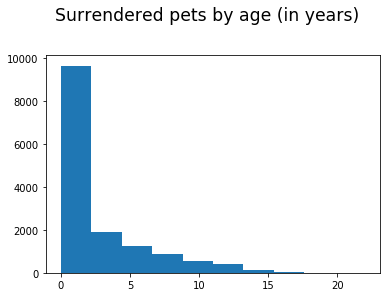

In [4]:
# Next, we want the distribution of surrenders by age

plt.hist(surrendered['age_numerical'])
plt.suptitle('Surrendered pets by age (in years)', x=0.5, y=1.05, ha='center', fontsize='xx-large')
plt.show()

We see that an overwhelming number of surrendered pets are kittens/puppies and juniors. One of the possibilities is that this this due to people having litters of kittens/puppies born and surrendering them together (so surrendering 4-6 young animals at once instead of one old one)?

Let's take a closer look at the youngest animals:


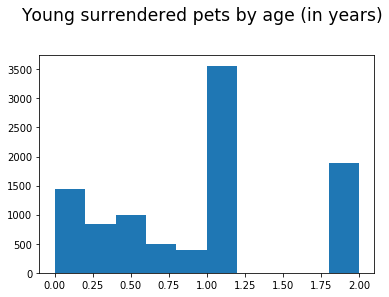

In [5]:
plt.hist(surrendered[surrendered['age_numerical']<=2].age_numerical)
plt.suptitle('Young surrendered pets by age (in years)', x=0.5, y=1.05, ha='center', fontsize='xx-large')
plt.show()

Notice that the gap here is an artifact of reporting: up to 1 year, the age is reported in month/weeks, and for pets above 1 year old the age is mostly reported in the whole number of years.

Surprisingly, the majority of young animals surrendered are very far from being newborns! This suggest that there are more factors in play than just people surrendering full litters of unwanted kittens/puppies. 

To further investigate this, I plotted the total number of intakes per month, and the number of surrenders. Since the dataset starts in October 2013 and end on the present day, I excluded dates in the ranges Oct-Dec 2013 and Jun-Feb 2018 from the consideration, so that each month would be counted the same number of times.



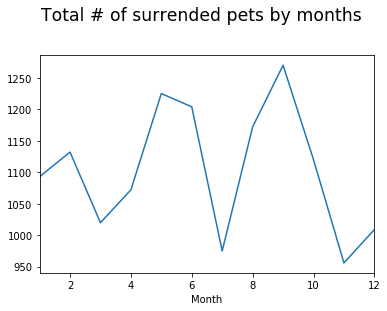

In [6]:
surrendered_2014_2017 = surrendered[(surrendered['datetime'].dt.year >= 2014) & (surrendered['datetime'].dt.year < 2018)]
intake_2014_2017 = intake[(intake['datetime'].dt.year >= 2014) & (intake['datetime'].dt.year < 2018)]

ax = surrendered_2014_2017.groupby(surrendered_2014_2017['datetime'].dt.month).count().animal_id.plot()
ax.set_xlabel("Month")
plt.suptitle('Total # of surrended pets by months', x=0.5, y=1.05, ha='center', fontsize='xx-large')
plt.show()

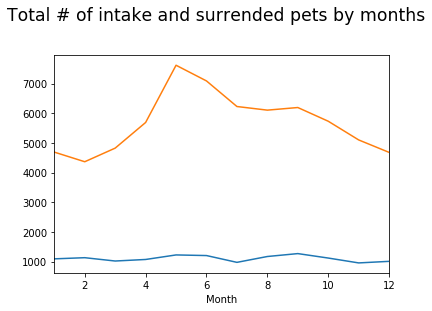

In [7]:
ax = surrendered_2014_2017.groupby(surrendered_2014_2017['datetime'].dt.month).count().animal_id.plot()
intake_2014_2017.groupby(intake_2014_2017['datetime'].dt.month).count().animal_id.plot(ax=ax)
ax.set_xlabel("Month")
plt.suptitle('Total # of intake and surrended pets by months', x=0.5, y=1.05, ha='center', fontsize='xx-large')
plt.show()

There is a very clear single spike of intakes around May. Most likely this corresponds to the so-called "kitten season" -- the time of year when most births of kittens (and puppies) occur.

However, the surrender data follows a different trend, so kittens (and puppies) being born at higher rates are not the only thing contributing to high surrender rate.

Part of the problem might be that young animals are just a handful. In this case the shelter might consider running an education program about dealing with young animals, or having discounted traning classes for puppies. Periodic check-ins with adopters of young animals could also help reduce the surrender rate.

## Shelter efficiency

This data can also give us information about shelter efficiency. For example, what is the percentage of pets wo end up getting adopted at all? What are the chances of pet who was healthy on intake to die while in shelter care? How long do the pets stay in the shelter, in general?

We'll start by plotting all the outcomes.

In [8]:
#TODO: make this prettier

labels = ['< 2 weeks', '2 wks - 2 mths', '3 mths - 6 mths','7mths - 2 yrs', '2 yrs - 6 yrs', '7 yrs - 10 yrs', '11+ yrs']

babies = outcomes[(outcomes['animal_type'] == 'Cat') & (outcomes['age_weeks'] < 2)].groupby('outcome_type').count().animal_id
kittens = outcomes[(outcomes['animal_type'] == 'Cat') & (outcomes['age_weeks'] >= 2) & (outcomes['age_months'] <=2)].groupby('outcome_type').count().animal_id
teens = outcomes[(outcomes['animal_type'] == 'Cat') & (outcomes['age_months'] >= 3) & (outcomes['age_months'] <=6)].groupby('outcome_type').count().animal_id
youth = outcomes[(outcomes['animal_type'] == 'Cat') & (outcomes['age_months'] >= 7) & (outcomes['age_years'] <=2)].groupby('outcome_type').count().animal_id
adults = outcomes[(outcomes['animal_type'] == 'Cat') & (outcomes['age_years'] >= 3) & (outcomes['age_years'] <=6)].groupby('outcome_type').count().animal_id
seniors = outcomes[(outcomes['animal_type'] == 'Cat') & (outcomes['age_years'] >= 7) & (outcomes['age_years'] <=10)].groupby('outcome_type').count().animal_id
oldies = outcomes[(outcomes['animal_type'] == 'Cat') & (outcomes['age_years'] >= 11)].groupby('outcome_type').count().animal_id

#not including very young baby kittens right now because they are not eligable for adoption
outcomes_by_age = pd.DataFrame([kittens,teens,youth,adults,seniors,oldies])
outcomes_by_age.index = labels[1:]

#also want the percentages..
outcomes_by_age_percent = outcomes_by_age.drop(['Rto-Adopt', 'Disposal','Transfer'], axis = 1)
outcomes_by_age_percent['total'] = outcomes_by_age_percent['Adoption'] + outcomes_by_age_percent['Died'] +  outcomes_by_age_percent['Euthanasia'] +outcomes_by_age_percent['Missing'] + outcomes_by_age_percent['Return to Owner']

outcomes_by_age_percent['Adoption']  = outcomes_by_age_percent['Adoption']/outcomes_by_age_percent['total'] *100
outcomes_by_age_percent['Died']  = outcomes_by_age_percent['Died']/outcomes_by_age_percent['total'] *100
outcomes_by_age_percent['Euthanasia']  =outcomes_by_age_percent['Euthanasia']/outcomes_by_age_percent['total'] *100
outcomes_by_age_percent['Missing']  = outcomes_by_age_percent['Missing']/outcomes_by_age_percent['total'] *100
outcomes_by_age_percent['Return to Owner']  = outcomes_by_age_percent['Return to Owner']/outcomes_by_age_percent['total']*100


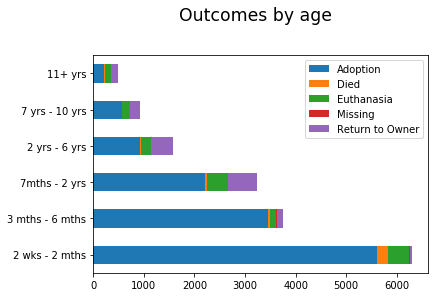

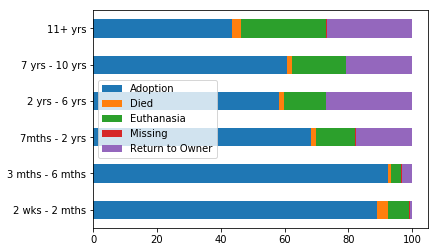

In [9]:
#Excluding irrelevant outcome types...
outcomes_by_age.drop(['Rto-Adopt', 'Disposal','Transfer'], axis = 1).plot(kind = 'barh', stacked = True)
plt.suptitle('Outcomes by age', x=0.5, y=1.05, ha='center', fontsize='xx-large')
outcomes_by_age_percent.drop(['total'], axis = 1).plot(kind = 'barh', stacked = True)
plt.show()

Notice that only outcome occuring within the shelter are included in these plots (live tranfers to other shelters are not included).

We can see that euthanasia rates increase with the age of the cat, which is to be expected. What is perhaps surprising is that kittens have a higher death rate than even most senior cats.

The reasons might be that the shelter does not have appropriate facilities to deal with the smallest kittens, or that kittens are not diagnosed in time. 

## Adoption factors

Finally, I would like to explore what characteristics make a cat more adoptable. While most of the characteristic included in the data are "immutable" -- we can't make a cat change its color to a more "adoptable" one -- this information can be used to increase chances of adoption by other means: for example, promote "less adoptable" animals on the organization's website or social metia, place them in a higher-traffic rooms at the shelter, etc.

In [10]:
cats_adopted_by_breed = outcomes[(outcomes['outcome_type'] == 'Adoption') & (outcomes['animal_type'] == 'Cat')].groupby('breed').count()
cats_intake_by_breed = intake[(intake['intake_condition'] == 'Normal') & (intake['animal_type'] == 'Cat')].groupby('breed').count()
cats_intake_by_breed['percentage_adopted'] = cats_adopted_by_breed['animal_id'] / cats_intake_by_breed['animal_id']*100

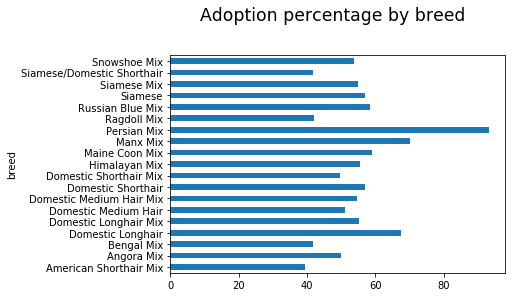

In [11]:
cats_intake_by_breed[(cats_intake_by_breed['animal_id'] > 10)].percentage_adopted.plot(kind='barh')
plt.suptitle('Adoption percentage by breed', x=0.5, y=1.05, ha='center', fontsize='xx-large')
plt.show()

Here I excluded the breeds with less than 10 entries. From this plot we can see two things (1) the data needs some cleaning (e.g. Domestic Shorthair Mix and Domestic Shorthair should probably be considered the same breed), and (2) with the exclusion of persian and manx, most "elite" breeds (like Ragdoll) surprisingly have the adoption rate lower than "generic" breeds (like domestic shorthair).


Other adoption factors to analyse include:

 * Color
 
  Do black cats really get adopted the least? Does a plain brown tabby have fewer chances to find a home than a beautiful pure white kitty? Or does color not matter that much, in the end? The color data need to be standardised and cleaned before this analysis can be made.
 
 * Age
 
 Common sense suggests that kittens would be adopted more than older cats, but more and more people come to shelters specifically looking for senior cats because of behavioral concerns. So which groups are the least likely to get adopted?
  Here the challenge is keeping track of the age of the animal during its time at the shelter, and handling animals with nultiple intake instances.
 
 * Length of stay at the shelter 
 
 Do cats who spent more time at the shelter more likely to get adopted (possibly because they are more socialized) or the other way around?